<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-3d">Code Library, Style, and Links</h1>

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d|ice|');
span {font-family:'Roboto'; color:black; text-shadow:5px 5px 5px #aaa;}  
div.output_area pre{font-family:'Roboto'; font-size:110%; color:steelblue;}      
</style>

In [2]:
import numpy as np,pandas as pd,keras as ks
import os,ast,cv2,warnings
import pylab as pl
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,\
classification_report
from keras.callbacks import ModelCheckpoint,\
ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation,Dropout,Dense,\
Conv2D,MaxPooling2D,GlobalMaxPooling2D
warnings.filterwarnings('ignore')
pl.style.use('seaborn-whitegrid')
style_dict={'background-color':'gainsboro','color':'steelblue', 
            'border-color':'white','font-family':'Roboto'}
fpath='../input/quickdraw-doodle-recognition/train_simplified/'
os.listdir("../input")

Using TensorFlow backend.


['quickdraw-doodle-recognition']

<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-3d">Data Exploration</h1>

In [3]:
I=64 # image size in pixels
S=2 # current number of the label set {1,...,17} -> {1-20,..., 321-340}
T=20 # number of labels in one set 
N=24000 # number of images with the same label in the training set
files=sorted(os.listdir(fpath))
labels=[el.replace(" ","_")[:-4] for el in files]
print(labels)

['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa', 'airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball_bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday_cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling_fan', 'cell_phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise_ship', 'cup', 'diamond', 'dis

In [4]:
def display_drawing():
    for k in range(5) :  
        pl.figure(figsize=(10,2))
        pl.suptitle(files[(S-1)*T+k])
        for i in range(5):
            picture=ast.literal_eval(data[labels[(S-1)*T+k]].values[i])
            for x,y in picture:
                pl.subplot(1,5,i+1)
                pl.plot(x,y,'-o',markersize=1,color='slategray')
                pl.xticks([]); pl.yticks([])
            pl.gca().invert_yaxis(); pl.axis('equal');            
def get_image(data,lw=7,time_color=True):
    data=ast.literal_eval(data)
    image=np.zeros((280,280),np.uint8)
    for t,s in enumerate(data):
        for i in range(len(s[0])-1):
            color=255-min(t,10)*15 if time_color else 255
            _=cv2.line(image,(s[0][i]+10,s[1][i]+10),
                       (s[0][i+1]+10,s[1][i+1]+10),color,lw) 
    return cv2.resize(image,(I,I))

In [5]:
data=pd.DataFrame(index=range(N),
                  columns=labels[(S-1)*T:S*T])
for i in range((S-1)*T,S*T):
    data[labels[i]]=\
    pd.read_csv(fpath+files[i],
                index_col='key_id').drawing.values[:N]
data.head(3).T.style.set_properties(**style_dict)

,0,1,2
basket,"[[[3, 40, 185, 191, 196, 203, 249], [14, 150, 151, 148, 107, 85, 11]], [[0, 59, 141, 216, 255], [15, 11, 10, 12, 16]], [[22, 47, 53], [20, 131, 146]], [[65, 83, 95, 102], [6, 77, 144, 159]], [[141, 143, 151, 159], [0, 87, 139, 158]], [[214, 216, 206], [11, 49, 120]], [[22, 144], [63, 62]]]","[[[180, 131, 96, 49, 7, 3, 6, 12, 42, 64, 92, 165, 180, 198, 219, 219, 212, 200], [14, 0, 0, 20, 46, 56, 67, 72, 90, 97, 101, 101, 98, 87, 68, 46, 33, 21]], [[0, 10, 33, 47, 54, 76, 119, 181, 201, 204], [61, 93, 142, 186, 195, 205, 212, 212, 134, 57]], [[30, 91, 165, 206, 210, 210], [122, 147, 168, 171, 167, 159]], [[47, 48, 63, 89, 159, 231], [157, 162, 170, 177, 192, 198]], [[46, 56, 73, 73], [107, 120, 193, 183]], [[84, 88, 98], [118, 125, 203]], [[130, 131, 123], [117, 166, 204]], [[170, 170, 160, 159], [99, 123, 159, 196]], [[180, 181, 150], [106, 132, 255]]]","[[[255, 241, 161, 45, 22, 15, 11, 8, 12, 23, 71, 140, 180, 224, 232, 241, 249, 253], [102, 100, 105, 91, 91, 95, 104, 182, 187, 191, 196, 197, 193, 193, 182, 125, 89, 87]], [[183, 188, 188, 185, 176, 165, 137, 112, 93, 87, 73, 72, 74, 77], [106, 64, 44, 35, 21, 12, 0, 3, 19, 28, 63, 88, 97, 98]], [[131, 129, 45, 42, 41], [97, 51, 48, 53, 88]], [[126, 169, 215, 217, 215, 211], [50, 47, 50, 73, 89, 92]], [[241, 207, 134, 52, 0], [123, 119, 118, 110, 110]], [[232, 224, 168], [147, 155, 193]], [[177, 152, 88], [100, 131, 191]], [[87, 75, 8], [100, 103, 180]], [[24, 56, 92], [97, 137, 200]], [[117, 144, 179], [103, 137, 198]]]"
basketball,"[[[131, 122, 104, 72, 21, 13, 2, 0, 5, 18, 43, 82, 173, 207, 228, 238, 253, 253, 210, 175, 108], [10, 5, 3, 18, 61, 70, 99, 159, 177, 204, 215, 222, 225, 220, 214, 205, 155, 94, 21, 10, 6]], [[41, 67, 76], [53, 69, 225]], [[231, 223, 200, 191, 193, 212], [64, 67, 98, 126, 167, 206]], [[124, 121, 112, 113], [11, 80, 115, 207]], [[145, 156, 161, 164, 164, 150], [0, 18, 38, 96, 133, 204]]]","[[[74, 54, 43, 26, 7, 1, 0, 4, 13, 32, 53, 86, 118, 153, 179, 209, 222, 231, 234, 225, 207, 188, 154, 73, 43, 36, 32], [0, 1, 7, 29, 66, 86, 111, 126, 139, 153, 163, 172, 177, 177, 173, 155, 140, 120, 88, 57, 36, 26, 16, 8, 13, 22, 34]], [[70, 67, 70, 86, 107, 151, 208, 229, 250, 255, 252], [5, 33, 69, 101, 118, 132, 132, 125, 113, 107, 101]], [[17, 21, 54, 75, 87, 87], [47, 58, 80, 105, 135, 169]]]","[[[211, 201, 179, 142, 109, 85, 51, 20, 10, 1, 0, 4, 13, 33, 53, 72, 91, 152, 207, 228, 239, 251, 255, 251, 245, 232, 217], [23, 14, 4, 0, 8, 22, 54, 98, 117, 150, 170, 190, 208, 228, 240, 242, 239, 215, 186, 168, 156, 131, 108, 71, 57, 43, 37]], [[144, 138, 114, 96], [15, 45, 131, 227]], [[51, 90, 119, 197, 224, 250], [70, 78, 79, 68, 58, 54]], [[18, 38, 57, 83, 106, 200, 249], [141, 126, 117, 112, 112, 132, 159]], [[16, 61, 110, 142, 192], [195, 197, 194, 189, 175]]]"
bat,"[[[111, 89, 79, 77, 82, 89, 103, 113, 126, 125, 104], [53, 106, 147, 174, 179, 180, 172, 156, 114, 54, 55]], [[103, 103, 111, 126, 137, 137, 127], [53, 17, 1, 2, 14, 25, 44]], [[113, 98, 45, 41, 40, 45, 27, 22, 21, 25, 20, 2, 0, 8, 42, 61, 73], [55, 48, 12, 10, 13, 53, 54, 61, 93, 125, 126, 115, 123, 136, 165, 167, 158]], [[132, 143, 158, 171, 208, 215, 219, 248, 251, 255, 254, 242, 227, 233, 233, 222, 211, 187, 144, 125, 111, 107], [61, 56, 37, 26, 12, 65, 67, 65, 67, 82, 102, 130, 153, 156, 160, 173, 180, 188, 189, 189, 186, 181]]]","[[[95, 95], [40, 73]], [[123, 124], [39, 65]], [[125, 67, 62, 52, 52, 56, 73, 106, 142, 152, 158, 158, 148, 136, 126], [5, 6, 11, 34, 55, 69, 85, 98, 98, 88, 70, 33, 13, 3, 0]], [[106, 115], [77, 77]], [[120, 122, 148, 180, 210, 223, 239, 245, 255, 254, 249, 238, 225, 204, 142, 128], [99, 177, 179, 159, 123, 94, 46, 51, 89, 124, 136, 154, 166, 174, 177, 173]], [[116, 29, 9, 4, 0, 1, 27, 45, 100, 122, 138], [151, 131, 101, 100, 113, 126, 165, 175, 185, 184, 169]], [[120, 113, 100, 90], [175, 192, 205, 209]], [[153, 158, 171], [184, 197, 209]]]","[[[88, 99, 104, 106, 128, 133, 144, 142, 146, 172, 213, 225, 243, 249, 253, 255, 254, 244, 234, 228, 202, 

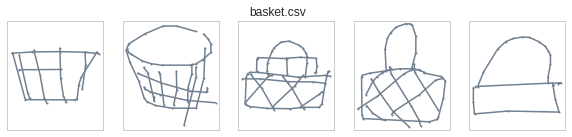

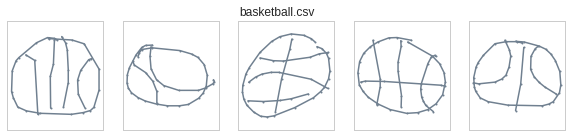

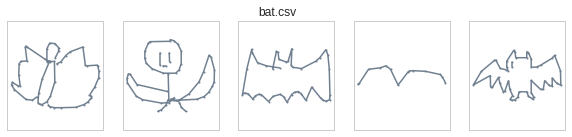

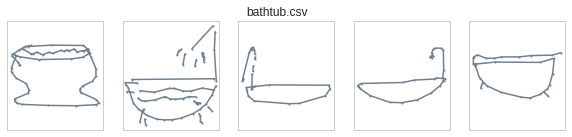

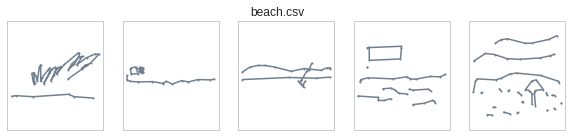

In [6]:
display_drawing()

In [7]:
images=[]
for label in labels[(S-1)*T:S*T]:
    images.extend([get_image(data[label].iloc[i]) 
                   for i in range(N)])
images=np.array(images,dtype=np.uint8)
targets=np.array([[]+N*[k] for k in range((S-1)*T,S*T)],
                 dtype=np.uint8).reshape(N*T)
del data
images.shape,targets.shape

((480000, 64, 64), (480000,))

In [8]:
images=images.reshape(-1,I,I,1)
x_train,x_test,y_train,y_test=\
train_test_split(images,targets,
                 test_size=.2,random_state=1)
n=int(len(x_test)/2)
x_valid,y_valid=x_test[:n],y_test[:n]
x_test,y_test=x_test[n:],y_test[n:]
del images,targets
[x_train.shape,x_valid.shape,x_test.shape,
 y_train.shape,y_valid.shape,y_test.shape]

[(384000, 64, 64, 1),
 (48000, 64, 64, 1),
 (48000, 64, 64, 1),
 (384000,),
 (48000,),
 (48000,)]

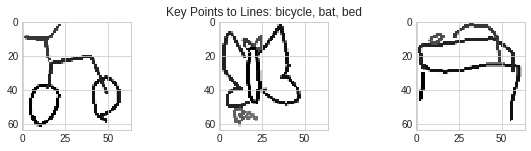

In [9]:
nn=np.random.randint(0,int(.8*T*N),3)
ll=labels[y_train[nn[0]]]+', '+labels[y_train[nn[1]]]+\
   ', '+labels[y_train[nn[2]]]
pl.figure(figsize=(10,2))
pl.subplot(1,3,1); pl.imshow(x_train[nn[0]].reshape(I,I))
pl.subplot(1,3,2); pl.imshow(x_train[nn[1]].reshape(I,I))
pl.subplot(1,3,3); pl.imshow(x_train[nn[2]].reshape(I,I))
pl.suptitle('Key Points to Lines: %s'%ll);

<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-3d">The Model</h1>

In [10]:
def model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=.02))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=.02))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(GlobalMaxPooling2D())   
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))   
    model.add(Dense(T))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
model=model()

In [11]:
fw='weights.best.model.cv021-040.hdf5'
checkpointer=\
ModelCheckpoint(filepath=fw,verbose=2,
                save_best_only=True)
lr_reduction=\
ReduceLROnPlateau(monitor='val_loss',
                  patience=5,verbose=2,factor=.75)
history=model.fit(x_train,y_train-(S-1)*T,epochs=100,
                  batch_size=1024,verbose=2,
                  validation_data=(x_valid,y_valid-(S-1)*T),
                  callbacks=[checkpointer,lr_reduction])

Train on 384000 samples, validate on 48000 samples
Epoch 1/100
 - 77s - loss: 10.1045 - acc: 0.1710 - val_loss: 1.7187 - val_acc: 0.4983

Epoch 00001: val_loss improved from inf to 1.71869, saving model to weights.best.model.cv021-040.hdf5
Epoch 2/100
 - 67s - loss: 1.5038 - acc: 0.5460 - val_loss: 1.2330 - val_acc: 0.6395

Epoch 00002: val_loss improved from 1.71869 to 1.23300, saving model to weights.best.model.cv021-040.hdf5
Epoch 3/100
 - 67s - loss: 1.2251 - acc: 0.6323 - val_loss: 1.0486 - val_acc: 0.6980

Epoch 00003: val_loss improved from 1.23300 to 1.04863, saving model to weights.best.model.cv021-040.hdf5
Epoch 4/100
 - 67s - loss: 1.0934 - acc: 0.6740 - val_loss: 0.9348 - val_acc: 0.7316

Epoch 00004: val_loss improved from 1.04863 to 0.93479, saving model to weights.best.model.cv021-040.hdf5
Epoch 5/100
 - 67s - loss: 1.0081 - acc: 0.7003 - val_loss: 0.8665 - val_acc: 0.7514

Epoch 00005: val_loss improved from 0.93479 to 0.86655, saving model to weights.best.model.cv021-0

<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-3d">Evaluation</h1>

In [12]:
model.load_weights(fw)
model.evaluate(x_test,y_test-(S-1)*T)

48000/48000 [==============================] - 4s 78us/step


[0.4530360355998079, 0.8710833333333333]

In [13]:
p_test=model.predict(x_test)
p_test=[np.argmax(x) for x in p_test]
p_test[:10]

[0, 8, 5, 17, 5, 8, 0, 14, 11, 11]

In [14]:
well_predicted=[]
for p in range(len(x_test)):
    if (p_test[p]+(S-1)*T==y_test[p]):
        well_predicted.append(labels[(S-1)*T+p_test[p]])
u=np.unique(well_predicted,return_counts=True)
pd.DataFrame({'labels':u[0],'correct predictions':u[1]})\
.sort_values('correct predictions',ascending=False)\
.style.set_properties(**style_dict)

,labels,correct predictions
18,boomerang,2275
11,bicycle,2275
14,birthday_cake,2266
8,bee,2244
1,basketball,2214
4,beach,2194
17,book,2185
10,bench,2095
9,belt,2095
3,bathtub,2072
